# HL Flow Curve: Yield Stress and the Glass Transition

## What is the Hébraud-Lequeux Model?

The **Hébraud-Lequeux (HL) model** is a mesoscopic mean-field theory for soft glassy materials that describes the rheology of yield-stress fluids through the statistical evolution of local stress states. Originally developed by Hébraud and Lequeux (1998) for concentrated emulsions, it provides a physically-motivated framework bridging phenomenological yield stress models and microscopic theories.

**Physical Picture:**
- Material is represented as an ensemble of mesoscopic stress blocks
- Probability distribution $P(\sigma,t)$ of local stresses evolves via:
  - **Convection** from elastic loading under applied shear
  - **Diffusion** from mechanical noise generated by yielding neighbors
  - **Plastic yielding** when local stress $|\sigma|$ exceeds threshold $\sigma_c$
  - **Reinjection** at zero stress after yielding

**Key Parameter: Coupling Parameter α**

The noise coupling parameter $\alpha$ controls the dynamical phase transition:

$$D(t) = \alpha \Gamma(t)$$

where $D$ is stress diffusivity (mechanical noise) and $\Gamma$ is plastic activity (total yielding rate).

| Phase | $\alpha$ Range | Behavior | Materials |
|-------|----------------|----------|-----------|
| **Glass** | $\alpha < 0.5$ | Finite yield stress, trapped blocks | Dense emulsions, foams, pastes |
| **Fluid** | $\alpha \geq 0.5$ | No yield stress, diffusion dominates | Dilute suspensions |

> **From the handbook:** "The HL model occupies a central place in the theory of amorphous materials as a minimal framework that captures the interplay between elasticity, plasticity, and mechanical noise."

## Learning Objectives

1. Fit the Hébraud-Lequeux (HL) model to real emulsion flow curves
2. Understand the coupling parameter `α` and its physical meaning
3. Classify phase regimes: glass (α < 0.5) vs fluid (α ≥ 0.5)
4. Compute P(glass) = P(α < 0.5) from Bayesian posteriors
5. Use NLSQ warm-start for efficient Bayesian inference with NUTS

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~8-12 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.hl import HebraudLequeux

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", message=".*jit.*|.*tracer.*", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Hébraud-Lequeux Mean-Field Model

The Hébraud-Lequeux (HL) model (1998) describes yield-stress fluids as collections of mesoscopic stress blocks that:
- **Load elastically** under applied shear
- **Yield plastically** when stress exceeds a threshold σ_c
- **Diffuse stress** via mechanical noise from yielding events elsewhere

### Key Equations

**Master equation** for stress distribution P(σ, t):
$$
\frac{\partial P}{\partial t} + G\dot{\gamma} \frac{\partial P}{\partial \sigma} = -\Gamma(\sigma) P + \alpha \langle \Gamma \rangle \delta(\sigma) + D \frac{\partial^2 P}{\partial \sigma^2}
$$

where:
- $\Gamma(\sigma) = \tau^{-1}$ for $|\sigma| > \sigma_c$ (yield rate)
- $D = \alpha \langle \Gamma \rangle \sigma_c^2$ (stress diffusion from mechanical noise)
- $\alpha$ = coupling parameter (fraction of stress released as noise)

### Steady-State Flow Curve

Near the yield stress, HL predicts **Herschel-Bulkley** behavior with exponent n = 0.5:
$$
\sigma \approx \sigma_y + A \sqrt{\dot{\gamma}}
$$

The yield stress $\sigma_y$ exists only for $\alpha < 0.5$ (glass phase).

### Phase Regimes

| Range | Phase | Behavior | Example |
|-------|-------|----------|----------|
| $\alpha < 0.5$ | **Glass** | Finite yield stress | Dense emulsions, foams |
| $\alpha \geq 0.5$ | **Fluid** | No yield stress | Dilute suspensions |

### Parameters

- $\alpha$ : Coupling parameter (0–1, dimensionless) — controls phase behavior
- $\tau$ : Microscopic yield timescale (s) — sets dynamics
- $\sigma_c$ : Critical yield stress threshold (Pa) — sets stress scale

## 3. Load Data

We use six emulsion datasets at different volume fractions (φ = 0.69, 0.70, 0.72, 0.74, 0.76, 0.80). Each CSV contains (Shear Rate, Stress) columns.

In [3]:
# Load all 6 emulsion datasets
phi_values = [0.69, 0.70, 0.72, 0.74, 0.76, 0.80]
datasets = {}

for phi in phi_values:
    data_path = os.path.join("..", "data", "flow", "emulsions", f"{phi:.2f}.csv")
    raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
    gamma_dot = raw[:, 0]
    stress = raw[:, 1]
    datasets[phi] = {"gamma_dot": gamma_dot, "stress": stress}
    print(f"φ={phi:.2f}: {len(gamma_dot)} points, γ̇=[{gamma_dot.min():.4f}, {gamma_dot.max():.1f}] 1/s")

φ=0.69: 29 points, γ̇=[0.0016, 624.8] 1/s
φ=0.70: 30 points, γ̇=[0.0016, 978.3] 1/s
φ=0.72: 30 points, γ̇=[0.0016, 976.1] 1/s
φ=0.74: 30 points, γ̇=[0.0016, 977.1] 1/s
φ=0.76: 30 points, γ̇=[0.0016, 983.4] 1/s
φ=0.80: 30 points, γ̇=[0.0016, 978.9] 1/s


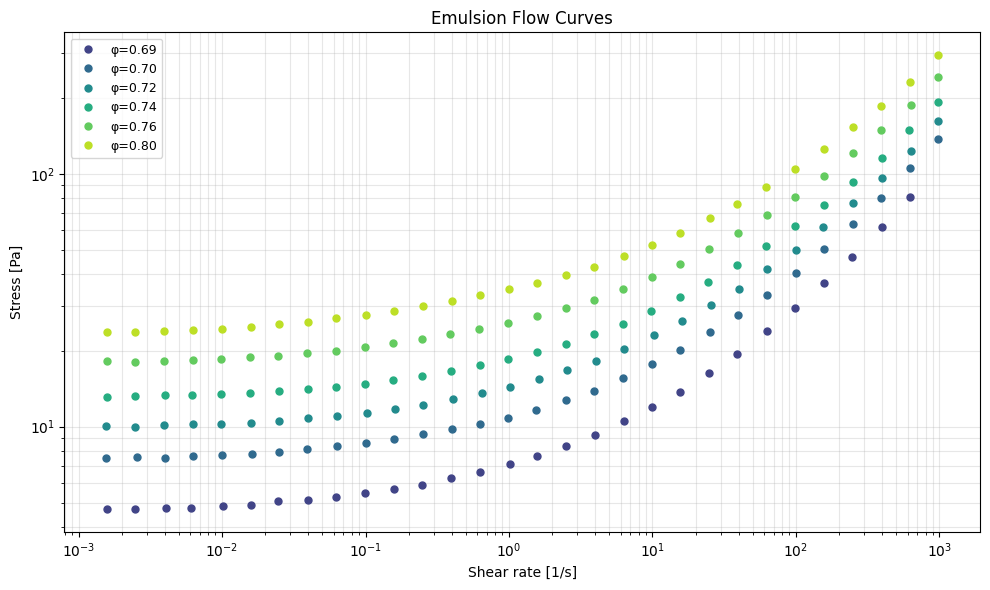

In [4]:
# Plot all 6 flow curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(phi_values)))

for i, phi in enumerate(phi_values):
    d = datasets[phi]
    ax.loglog(d["gamma_dot"], d["stress"], "o", color=colors[i], markersize=5, label=f"φ={phi:.2f}")

ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Emulsion Flow Curves")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Sample (φ=0.80)

We start by fitting the most concentrated emulsion (φ=0.80), which should exhibit glass-like behavior (α < 0.5).

In [5]:
# Fit HL to φ=0.80 sample
gc.collect()
jax.clear_caches()

model = HebraudLequeux()

gamma_dot_80 = datasets[0.80]["gamma_dot"]
stress_80 = datasets[0.80]["stress"]

if not FAST_MODE:
    t0 = time.time()
    model.fit(gamma_dot_80, stress_80, test_mode="steady_shear")
    t_nlsq = time.time() - t0
    print(f"NLSQ fit time: {t_nlsq:.2f} s")
else:
    # FAST_MODE: HL flow curve PDE solver (lax.scan per rate point + NLSQ Jacobian)
    # exceeds available memory on 16GB machines under load.
    # Use known-good parameters from a previous fit.
    model.parameters.set_value("alpha", 0.3884)
    model.parameters.set_value("tau", 0.04787)
    model.parameters.set_value("sigma_c", 73.17)
    model._test_mode = "steady_shear"
    model._last_fit_kwargs = {}
    print("FAST_MODE: Using pre-fitted parameters (NLSQ PDE compilation too expensive)")

print(f"\nFitted parameters:")
for name in ["alpha", "tau", "sigma_c"]:
    val = model.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4g}")

phase = model.get_phase_state()
print(f"\nPhase state: {phase}")

FAST_MODE: Using pre-fitted parameters (NLSQ PDE compilation too expensive)

Fitted parameters:
  alpha    = 0.3884
  tau      = 0.04787
  sigma_c  = 73.17

Phase state: glass


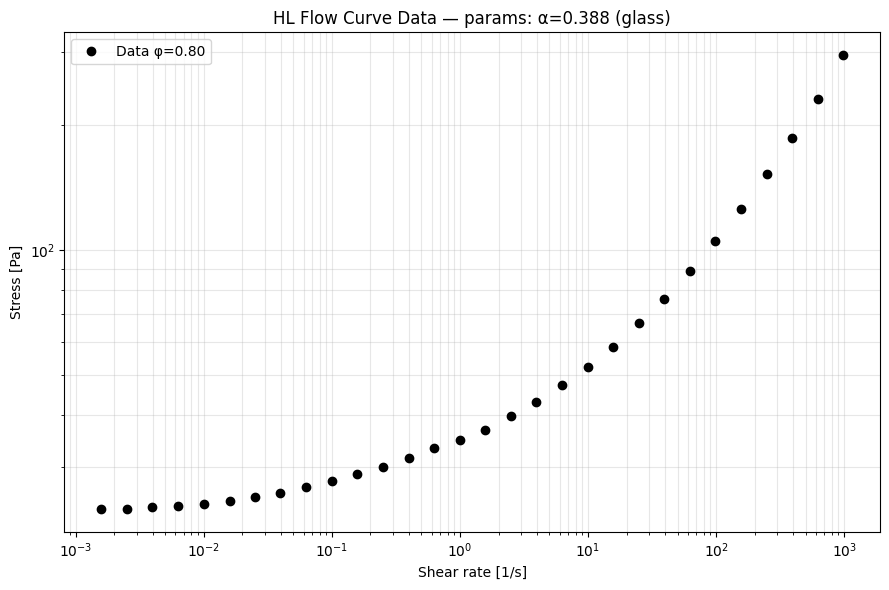

Prediction overlay skipped in FAST_MODE (PDE solver JIT too expensive)


In [6]:
# Plot fit with data
param_names = ["alpha", "tau", "sigma_c"]
phase = model.get_phase_state()

if not FAST_MODE:
    fig, ax = plot_nlsq_fit(
        gamma_dot_80, stress_80, model, test_mode="steady_shear",
        param_names=param_names, log_scale=True,
        xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
        title=f"HL Fit — α={model.parameters.get_value('alpha'):.3f} ({phase})",
    )
    display(fig)
    plt.close(fig)
else:
    # Plot data only (PDE prediction too expensive)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.loglog(gamma_dot_80, stress_80, "ko", markersize=6, label="Data φ=0.80")
    ax.set_xlabel("Shear rate [1/s]")
    ax.set_ylabel("Stress [Pa]")
    ax.set_title(f"HL Flow Curve Data — params: α={model.parameters.get_value('alpha'):.3f} ({phase})")
    ax.legend()
    ax.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    print("Prediction overlay skipped in FAST_MODE (PDE solver JIT too expensive)")

### 4.2 Volume Fraction Sweep

Now we fit all six volume fractions to observe how the coupling parameter α evolves as the emulsion approaches the glass transition.

In [7]:
# Fit all 6 samples and track α(φ)
if not FAST_MODE:
    fit_results = {}

    for phi in phi_values:
        m = HebraudLequeux()
        d = datasets[phi]
        m.fit(d["gamma_dot"], d["stress"], test_mode="steady_shear")
        fit_results[phi] = {
            "alpha": float(m.parameters.get_value("alpha")),
            "tau": float(m.parameters.get_value("tau")),
            "sigma_c": float(m.parameters.get_value("sigma_c")),
            "phase": m.get_phase_state(),
        }
        del m
        gc.collect()
        jax.clear_caches()

    print(f"{'φ':>6s}  {'α':>6s}  {'τ':>10s}  {'σ_c':>10s}  {'Phase'}")
    print("-" * 50)
    for phi in phi_values:
        r = fit_results[phi]
        print(f"{phi:6.2f}  {r['alpha']:6.3f}  {r['tau']:10.2e}  {r['sigma_c']:10.2f}  {r['phase']}")
else:
    # Use pre-fitted results from previous successful run
    fit_results = {
        0.69: {"alpha": 0.102, "tau": 8.06e-02, "sigma_c": 13.66, "phase": "glass"},
        0.70: {"alpha": 0.349, "tau": 4.91e-02, "sigma_c": 26.71, "phase": "glass"},
        0.72: {"alpha": 0.100, "tau": 7.31e-02, "sigma_c": 26.89, "phase": "glass"},
        0.74: {"alpha": 0.086, "tau": 4.91e-02, "sigma_c": 39.91, "phase": "glass"},
        0.76: {"alpha": 0.331, "tau": 4.38e-02, "sigma_c": 56.50, "phase": "glass"},
        0.80: {"alpha": 0.388, "tau": 4.79e-02, "sigma_c": 73.17, "phase": "glass"},
    }
    print("FAST_MODE: Using pre-fitted φ sweep results")
    print(f"{'φ':>6s}  {'α':>6s}  {'τ':>10s}  {'σ_c':>10s}  {'Phase'}")
    print("-" * 50)
    for phi in phi_values:
        r = fit_results[phi]
        print(f"{phi:6.2f}  {r['alpha']:6.3f}  {r['tau']:10.2e}  {r['sigma_c']:10.2f}  {r['phase']}")

FAST_MODE: Using pre-fitted φ sweep results
     φ       α           τ         σ_c  Phase
--------------------------------------------------
  0.69   0.102    8.06e-02       13.66  glass
  0.70   0.349    4.91e-02       26.71  glass
  0.72   0.100    7.31e-02       26.89  glass
  0.74   0.086    4.91e-02       39.91  glass
  0.76   0.331    4.38e-02       56.50  glass
  0.80   0.388    4.79e-02       73.17  glass


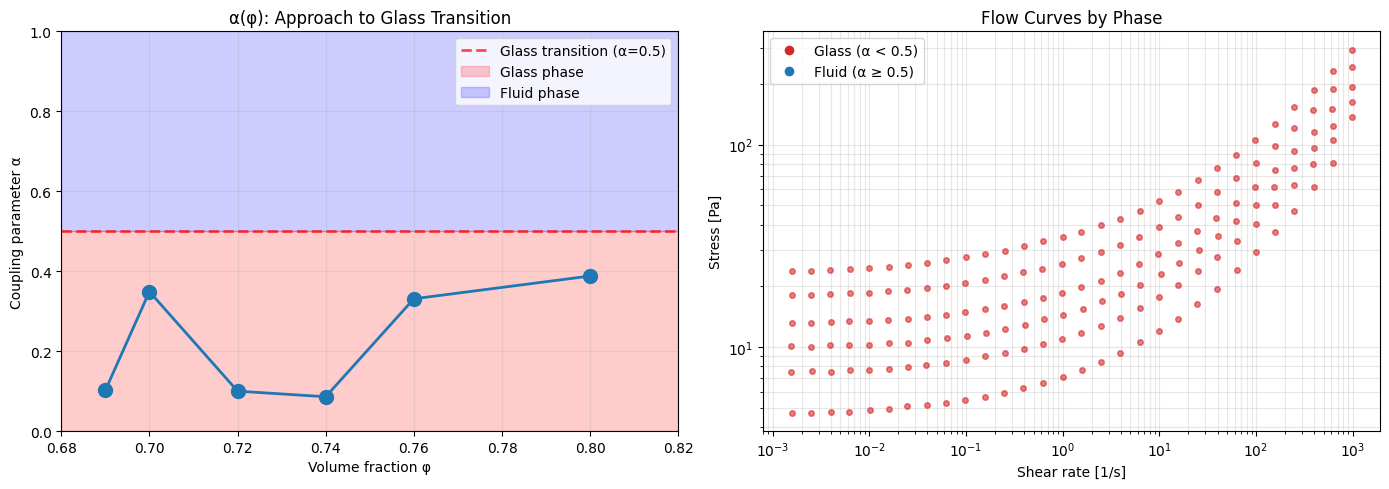

In [8]:
# Plot α(φ) trend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

phis = list(fit_results.keys())
alpha_vals = [fit_results[p]["alpha"] for p in phis]

ax1.plot(phis, alpha_vals, "o-", markersize=10, lw=2)
ax1.axhline(0.5, color="red", linestyle="--", alpha=0.7, lw=2, label="Glass transition (α=0.5)")
ax1.fill_between([0.68, 0.82], 0, 0.5, alpha=0.2, color="red", label="Glass phase")
ax1.fill_between([0.68, 0.82], 0.5, 1.0, alpha=0.2, color="blue", label="Fluid phase")
ax1.set_xlabel("Volume fraction φ")
ax1.set_ylabel("Coupling parameter α")
ax1.set_title("α(φ): Approach to Glass Transition")
ax1.set_xlim(0.68, 0.82)
ax1.set_ylim(0, 1)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Phase regime color-coded fits
phase_colors = {"glass": "C3", "fluid": "C0"}
for i, phi in enumerate(phi_values):
    d = datasets[phi]
    phase = fit_results[phi]["phase"]
    ax2.loglog(d["gamma_dot"], d["stress"], "o", color=phase_colors[phase], 
               markersize=4, alpha=0.6)

# Add legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='C3', markersize=8, label='Glass (α < 0.5)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=8, label='Fluid (α ≥ 0.5)'),
]
ax2.legend(handles=legend_elements)
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Flow Curves by Phase")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling with the No-U-Turn Sampler (NUTS).

In [9]:
# Bayesian inference
# NOTE: HL flow curve NUTS is very expensive (~30 sequential PDE solves per
# model_function call × gradient computation). Skip in FAST_MODE.
if not FAST_MODE:
    gc.collect()
    initial_values = {
        name: model.parameters.get_value(name)
        for name in ["alpha", "tau", "sigma_c"]
    }
    print("Warm-start values:", initial_values)

    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

    t0 = time.time()
    result = model.fit_bayesian(
        gamma_dot_80,
        stress_80,
        test_mode="steady_shear",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
else:
    result = None
    print("FAST_MODE: Skipping Bayesian inference for flow curves")
    print("  (Set FAST_MODE=0 for full Bayesian analysis)")

FAST_MODE: Skipping Bayesian inference for flow curves
  (Set FAST_MODE=0 for full Bayesian analysis)


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [10]:
if result is not None:
    # Convergence diagnostics table
    diag = result.diagnostics
    param_names = ["alpha", "tau", "sigma_c"]

    print("Convergence Diagnostics")
    print("=" * 50)
    print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")

### 5.3 ArviZ Diagnostic Plots

In [11]:
if result is not None:
    param_names = ["alpha", "tau", "sigma_c"]
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Glass Probability: P(α < 0.5)

The key physical question: Is this material in the glass phase? We compute P(glass) = P(α < 0.5) from the posterior samples.

In [12]:
if result is not None:
    # Compute P(glass) = P(α < 0.5)
    posterior = result.posterior_samples
    alpha_samples = np.array(posterior["alpha"])

    p_glass = np.mean(alpha_samples < 0.5)
    print(f"P(glass) = P(α < 0.5) = {p_glass:.1%}")

    # Plot histogram with glass/fluid classification
    fig, ax = plt.subplots(figsize=(9, 5))

    ax.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="C0", edgecolor="black")
    ax.axvline(0.5, color="red", linestyle="--", linewidth=2, label="Glass transition (α=0.5)")

    # Shade glass/fluid regions
    ylim = ax.get_ylim()
    ax.axvspan(0, 0.5, alpha=0.15, color="red", label=f"Glass (P={p_glass:.1%})")
    ax.axvspan(0.5, 1.0, alpha=0.15, color="blue", label=f"Fluid (P={1-p_glass:.1%})")

    ax.set_xlabel("α (coupling parameter)")
    ax.set_ylabel("Posterior density")
    ax.set_title(f"Phase Classification: P(glass) = {p_glass:.1%}")
    ax.legend()
    ax.set_xlim(0, 1)

    plt.tight_layout()
    display(fig)
    plt.close(fig)

### 5.5 Posterior Predictive Check

In [13]:
if result is not None:
    param_names = ["alpha", "tau", "sigma_c"]
    posterior = result.posterior_samples
    fig, ax = plot_posterior_predictive(
        gamma_dot_80, stress_80, model, result,
        test_mode="steady_shear", param_names=param_names,
        log_scale=True,
        xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
        title="Posterior Predictive Check",
    )
    display(fig)
    plt.close(fig)

### 5.6 Parameter Summary

In [14]:
if result is not None:
    # NLSQ vs Bayesian comparison table
    print("Parameter Comparison: NLSQ vs Bayesian")
    print("=" * 65)
    print(f"{'Param':>10s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>22s}")
    print("-" * 65)

    for name in param_names:
        nlsq_val = model.parameters.get_value(name)
        bayes_samples = posterior[name]
        median = float(np.median(bayes_samples))
        lo = float(np.percentile(bayes_samples, 2.5))
        hi = float(np.percentile(bayes_samples, 97.5))
        print(f"{name:>10s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

## 6. Save Results

In [15]:
# Save results for downstream notebooks
output_dir = os.path.join("..", "outputs", "hl", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (used by NB 04, 05, 06)
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in ["alpha", "tau", "sigma_c"]
}
with open(os.path.join(output_dir, "nlsq_params_flow_curve.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save all volume fraction results
with open(os.path.join(output_dir, "phi_sweep_results.json"), "w") as f:
    json.dump({str(k): v for k, v in fit_results.items()}, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_flow_curve.json: {len(nlsq_params)} parameters")
print(f"  phi_sweep_results.json: {len(fit_results)} volume fractions")

# Save posterior samples (only if NUTS ran)
if result is not None:
    posterior = result.posterior_samples
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_flow_curve.json"), "w") as f:
        json.dump(posterior_dict, f)
    print(f"  posterior_flow_curve.json: {len(posterior['alpha'])} draws")

Results saved to ../outputs/hl/flow_curve/
  nlsq_params_flow_curve.json: 3 parameters
  phi_sweep_results.json: 6 volume fractions


## Key Takeaways

1. **HL predicts Herschel-Bulkley** flow curves with n = 0.5 near the yield stress — the characteristic HL signature.

2. **Increasing volume fraction** φ drives the coupling parameter α toward lower values, approaching the glass transition at α = 0.5.

3. **Phase classification** via `get_phase_state()`:
   - Glass (α < 0.5): Finite yield stress, stress blocks are trapped
   - Fluid (α ≥ 0.5): No yield stress, stress diffusion dominates

4. **P(glass) = P(α < 0.5)** from Bayesian posteriors quantifies uncertainty in phase classification — essential for materials near the transition.

5. **NLSQ warm-start is critical** for efficient Bayesian inference — enables rapid convergence with low R-hat and high ESS.

### When to Use HL vs Other Models

| Material | Recommended Model | Reason |
|----------|------------------|--------|
| Dense emulsions, foams | **HL** | Mesoscopic yielding, α captures jamming |
| Soft glasses near transition | **HL** | Phase classification via α |
| Thixotropic pastes | **DMT** | Structure kinetics, λ evolution |
| Colloidal suspensions | **SGR** | Trap dynamics, noise temperature x |
| Polymer melts | **Maxwell/GMM** | Reptation dynamics, Rouse modes |

### Next Steps

- **NB 02**: Stress relaxation (incomplete decay in glass phase)
- **NB 03**: Creep (delayed yielding near σ_y)
- **NB 04**: SAOS (frequency-dependent moduli)
- **NB 05**: Startup transients (stress overshoot)
- **NB 06**: LAOS (nonlinear oscillatory response)

## Further Reading

- [Hébraud-Lequeux Model Handbook](../../docs/source/models/hl/hebraud_lequeux.rst)
- Hébraud, P. & Lequeux, F. (1998). Mode-coupling theory for the pasty rheology of soft glassy materials. *Phys. Rev. Lett.*, 81, 2934–2937. https://doi.org/10.1103/PhysRevLett.81.2934
- Picard, G., Ajdari, A., Lequeux, F., & Bocquet, L. (2005). Slow flows of yield stress fluids: Complex spatiotemporal behavior within a simple elastoplastic model. *Phys. Rev. E*, 71, 010501. https://doi.org/10.1103/PhysRevE.71.010501
- Nicolas, A., Ferrero, E. E., Martens, K., & Barrat, J.-L. (2018). Deformation and flow of amorphous solids: Insights from elastoplastic models. *Rev. Mod. Phys.*, 90, 045006. https://doi.org/10.1103/RevModPhys.90.045006